In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Read dataset

In [16]:
import pickle as pkl
import json
import ast
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data1(path = "DataSet/"):
    split = [0.75,0.15,0.15]
    path_set = os.listdir(path)
    data_train_X = []
    data_validation_X = []
    data_test_X = []
    data_train_Y = []
    data_validation_Y = []
    data_test_Y = []
    data_A = []
    index = 0
    nb_total = len(path_set)
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])

        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])

        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
#         print(data_cons.shape)
#         print(data_var.shape)
        data_cons = np.hstack((data_cons,np.zeros((data_cons.shape[0],19))))
        data_var = np.hstack((np.zeros((data_var.shape[0],5)),data_var))
        
        matrix_A = np.vstack((data_cons,data_var))
        data_A.append(matrix_A)
    #     print(matrix_A.shape)
        if index < nb_total * split[0]:
#             print(filename)
            data_train_X.append(data_var)
            data_train_Y.append(data_label)
        elif index < nb_total * split[1]:
            data_validation_X.append(data_var)
            data_validation_Y.append(data_label)
        else:
            data_test_X.append(data_var)
            data_test_Y.append(data_label)
        index += 1
    return     np.array(data_train_X),np.array(data_train_Y),np.array(data_validation_X),np.array(data_validation_Y),np.array(data_test_X),np.array(data_test_Y),np.array(data_A)
data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
print(data_train_X.shape)
print(data_train_Y.shape)
print(A.shape)

0	0	0	0	0	1	1	0	1	1	
0	0	0	0	0	1	1	1	0	1	
0	0	0	0	0	0	1	1	1	1	
0	0	0	0	0	1	1	1	1	0	
0	0	0	0	0	1	1	0	1	1	
1	1	0	1	1	0	0	0	0	0	
1	1	1	1	1	0	0	0	0	0	
0	1	1	1	0	0	0	0	0	0	
1	0	1	1	1	0	0	0	0	0	
1	1	1	0	1	0	0	0	0	0	


ValueError: too many values to unpack (expected 7)

In [54]:
import pickle as pkl
import json
import ast
np.set_printoptions(threshold=np.inf)
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet/"):
    path_set = os.listdir(path)
    dataSet = []
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])
        nb_cons = data_cons.shape[0]
        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])
        nb_var = data_var.shape[0]
        #compose H
        data_cons = np.hstack((np.zeros((data_cons.shape[0],19)),data_cons))
        data_var = np.hstack((data_var,np.zeros((data_var.shape[0],5))))
        matrix_H = np.vstack((data_var,data_cons))
        
        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data = json.load(edges_file)
        matrix_A = np.zeros((nb_cons+nb_var,nb_cons+nb_var))
        for i in range(len(data["values"])):
            iVar,iCons = data["indices"][1][i],data["indices"][0][i] 
            matrix_A[iVar][nb_var+iCons] = data["values"][i]
            matrix_A[iCons+nb_var][iVar] = data["values"][i]
        
        dataSet.append({"X":matrix_H,"Y":data_label,"A":matrix_A})
        
    return np.array(dataSet)
split = [0.70,0.15,0.15]
dataSet = load_data()
data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# GCN






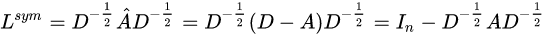

In [158]:
class MLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.activate = nn.ReLU()
        
    def forward(self, x, A):
        x = self.linear(x)
        
        print(x[0])
        print(A[0])

        x = self.activate(x)
        print(x[0])
        x = A.mm(x)       
        print(x[0])
        return x
    
class Net(nn.Module):
    def __init__(self, in_channel,aux_channel,out_channel):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, aux_channel),
        )
#         self.m = nn.log_softmax()
        self.mlp = MLP(in_channel, aux_channel)
        self.outlayer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, out_channel),
        )
    
    def forward(self, x, A,nb_net):
        x = self.mlp(x,A)
        for i in range(nb_net):
            x = self.layer(x)
        x = self.outlayer(x)
#         x = self.m(x)
#         print(x[0]) 
        return x

    

## Train


In [159]:
def train(model, x, y,A, optimizer,nb_net,criterion):
    model.zero_grad()
    size_y = len(y)
    output = model(x.float(),A.float(),nb_net)
#     print(output)
    loss =criterion(output,y)
    loss.backward()
    optimizer.step()

    return loss, output

In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(24,50,1).float()
nb_net = 2
EPOCHS = 200
optm = Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    for i in tqdm(range(len(data_train))):
        x_train, y_train = torch.from_numpy(data_train[i]['X'].astype(float)),torch.from_numpy(data_train[i]['Y'])
        A = torch.from_numpy(data_train[i]['A'].astype(float))
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        loss, predictions = train(net,x_train,y_train,A,optm,nb_net, criterion)


  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

tensor([1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, -0.0000, 0.4737, 0.4737,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3508, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([ 8.9114e-02, -5.9544e-02,  5.9618e-01,  1.7717e-01,  3.6322e-01,
         2.4550e-01,  1.5632e-01, -2.7786e-01, -1.5852e-01, -3.8170e-01,
        -5.7730e-02, -2.0541e-01, -3.7464e-01,  5.2798e-01,  9.9224e-02,
        -6.0221e-01,  4.2229e-01, -2.7891e-01, -3.4535e-01, -2.1614e-01,
         2.1223e-01, -1.9057e-01,  7.7581e-01,  6.0380e-01, -4.5941e-02,
         2.7219e-01,  9.2523e-02,  2.1383e-01, -5.3906e-04,  6.3306e-02,
         2.2965e-01, -4.4949e-01, -4.9438e-01,  2.9999e-02,  4.8279e-02,
        -4.8719e-01, -1.7914e-02,  2.9808e-01,  2.9708e-01, -3.9331e-01,
         1.4757e-01, -5.9299e-02,  4.0617e-01,  5.1369e-01,  1.4808e-01,
         5.2780e-02, -4.3141e-01,  1.0196e-01,  1.8061e-02,  1.4898e-01],
       grad_fn=<SelectBackward

ValueError: Expected input batch_size (200) to match target batch_size (100).